### Import required packages:

In [2]:
import numpy as np
import astropy.io.fits
import random
import os
import os.path
import cv2
from collections import Counter
from PIL import Image
from sklearn.cluster import KMeans
from astropy.time import Time
import csv
from statistics import stdev
from statistics import mean
import math
import matplotlib.pyplot as plt
import pandas as pd

### Functions:

In [3]:
# Normalizing between [1,-1]
def normal(feature):
    feature = feature - feature.mean()
    feature = feature / feature.max()
    return feature

# Getting Features

def getFeatures(Name):
    fileData = astropy.io.fits.open(Name)
    B = fileData[1].data
    B = np.array(B, dtype=np.float64)
    Binc = fileData[2].data
    Binc = np.array(Binc, dtype=np.float64)
    Bazi = fileData[3].data
    Bazi = np.array(Bazi, dtype=np.float64)
    DopF = fileData[4].data
    DopF = np.array(DopF, dtype=np.float64)
    #DopS = fileData[5].data
    #DopS = np.array(DopS, dtype=np.float64)
    SLFF = fileData[12].data
    SLFF = np.array(SLFF, dtype=np.float64)
    CI = fileData[32].data
    CI = np.array(CI, dtype=np.float64)


    return B, Binc, Bazi, DopF, SLFF, CI

# Getting different centroids

def getCenteroids(list):
    centroidsList = random.shuffle(list)
    return centroidsList


# Resizing Feature to 512*512
def res(img):
    resize = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    return resize

# Square and sum of elements in substracting matrix
def ss(mat):
    a = np.square(mat)
    b = np.sum(a)
    return b

# calculating Centroids

def CalCentroid(cluster):
    length = len(cluster)
    Bsum = np.zeros((512,512), dtype=np.float64)
    Bincsum = np.zeros((512,512), dtype=np.float64)
    Bazisum = np.zeros((512,512), dtype=np.float64)
    DopFsum = np.zeros((512,512), dtype=np.float64)
    DopSsum = np.zeros((512,512), dtype=np.float64)
    SLFFsum = np.zeros((512,512), dtype=np.float64)
    CIsum = np.zeros((512,512), dtype=np.float64)
    for i in cluster:
        file = ReadFits(i)
        B, Binc, Bazi, DopF, DopS, SLFF, CI = getFeatures(file)
        Bsum = np.add(Bsum, normal(res(B)))
        Bincsum = np.add(Bincsum, normal(res(Binc))) 
        Bazisum = np.add(Bazisum, normal(res(Bazi))) 
        DopFsum = np.add(DopFsum, normal(res(DopF))) 
        DopSsum = np.add(DopSsum, normal(res(DopS))) 
        SLFFsum = np.add(SLFFsum, normal(res(SLFF))) 
        CIsum = np.add(CIsum, normal(res(CI))) 
        
    BC = np.divide(Bsum, length) 
    BincC = np.divide(Bincsum, length) 
    BaziC = np.divide(Bazisum, length) 
    DopFC = np.divide(DopFsum, length) 
    DopSC = np.divide(DopSsum, length) 
    SLFFC = np.divide(SLFFsum, length) 
    CIC = np.divide(CIsum, length)
    
    return BC, BincC, BaziC, DopFC, DopSC, SLFFC, CIC


# Removing that effect due to doppler shifts

def canNoise(Doppler):
    
    y = np.mean(Doppler, 0)
    x = np.array(range(Doppler.shape[1]))
    m, b = np.polyfit(x, y, 1)
    v = m*x + b
    out = Doppler - v

    return out


# getting mean and max of features

def meanmax(feature):

    featuremean = feature.mean()
    featuremax = feature.max()
    return featuremean, featuremax

# Getting original values

def unnormalCenter(numpyarray):
    
    a = np.multiply(numpyarray[0], Btotmax)
    Bcen = np.add(a, Btotmean)
    
    b = np.arccos(numpyarray[1])
    Binccen = np.degrees(b)
    
    c = np.arccos(numpyarray[2])
    Bazicen = np.degrees(c)
    
    d = np.multiply(numpyarray[3], DopFtotmax)
    DopFcen = np.add(d, DopFtotmean)
    
    #e = np.multiply(numpyarray[4], DopStotmax)
    #DopScen = np.add(e, DopStotmean)
    
    f = np.multiply(numpyarray[4], SLFFtotmax)
    SLFFcen = np.add(f, SLFFtotmean)
    
    g = np.multiply(numpyarray[5], CItotmax)
    CIcen = np.add(g, CItotmean)
    
    return Bcen, Binccen, Bazicen, DopFcen, SLFFcen, CIcen 



# Normalizing angles

def normangle(feature):
    
    
    a = np.cos(np.deg2rad(feature))
    
    return a


# Plotting the image

def pltimg(array, dim, i, k):
    
    if k == 10:
        img_array = []
        for x in array:
            if x == 0:
                img_array.append((255,0,0)) # RED
            elif x == 1:
                img_array.append((128,128,0)) # OLIVE
            elif x == 2:
                img_array.append((0,255,0)) # GREEN
            elif x == 3:
                img_array.append((0,0,255)) # BLUE
            elif x == 4:
                img_array.append((255,255,255)) # BLACK
            elif x == 5:
                img_array.append((0,0,0)) # WHITE
            elif x == 6:
                img_array.append((128,0,128)) # PURPLE
            elif x == 7:
                img_array.append((0,128,128)) # TEAL
            elif x == 8:
                img_array.append((0,0,128)) # NAVY
            elif x == 9:
                img_array.append((128,0,0)) # MAROON

        fileData = (NewList[i])
        v = fileData[42:-5]
        img = Image.new('RGB', dim)
        img.putdata(img_array)
        img.save('north10/'+ v + '.png')
    
    elif k == 3:
        
        img_array = []
        for x in array:
            if x == 0:
                img_array.append((255,0,0)) # RED
            elif x == 1:
                img_array.append((255,255,255)) # BLACK
            elif x == 2:
                img_array.append((0,0,0)) # WHITE

        fileData = (NewList[i])
        v = fileData[42:-5]
        img = Image.new('RGB', dim)
        img.putdata(img_array)
        img.save('north3/'+ v + '.png')
    
    elif k == 4:
        
        img_array = []
        for x in array:
            if x == 0:
                img_array.append((255,0,0)) # RED
            elif x == 1:
                img_array.append((0,0,255)) # BLUE
            elif x == 2:
                img_array.append((255,255,255)) # BLACK
            elif x == 3:
                img_array.append((0,0,0)) # WHITE

        fileData = (NewList[i])
        v = fileData[42:-5]
        img = Image.new('RGB', dim)
        img.putdata(img_array)
        img.save('north4/'+ v + '.png')
        
    elif k == 5:
        
        img_array = []
        
        for x in array:
            if x == 0:
                img_array.append((255,0,0)) # RED
            elif x == 1:
                img_array.append((0,255,0)) # GREEN
            elif x == 2:
                img_array.append((0,0,255)) # BLUE
            elif x == 3:
                img_array.append((255,255,255)) # BLACK
            elif x == 4:
                img_array.append((0,0,0)) # WHITE
                
        fileData = (NewList[i])
        v = fileData[42:-5]
        img = Image.new('RGB',dim)
        img.putdata(img_array)
        img.save('north5/'+ v + '.png')
        
        

# Making a list for dimensions of observations
def dimlist(filenames):
    
    dimList = list()


    for i in NewList:

        file = astropy.io.fits.open(i)
        y, x = file[1].data.shape
        dimList.append((x, y))
    
    return dimList


# Concatenating all the observations

def concatfeatures(NewList):

    Btot, Binctot, Bazitot, DopFtot, DopStot, SLFFtot, CItot = np.array([]), np.array([]),np.array([]),\
                                np.array([]),np.array([]),np.array([]),np.array([])



    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        Binctot = np.concatenate((Binctot, Binc), axis=None)
        Bazitot = np.concatenate((Bazitot, Bazi), axis=None)
        DopFtot = np.concatenate((DopFtot, canNoise(DopF)), axis=None)
        #DopStot = np.concatenate((DopStot, canNoise(DopS)), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)
    
    
    return Btot, Binctot, Bazitot, DopFtot, SLFFtot, CItot


# Plot mappings
def pltmaps(labels, dimList, k):
    
    start = 0
    end = 0

    for s, tple in enumerate(dimList):

        end += tple[0] * tple[1]

        pltimg(labels[start:end], tple, s, k)

        start = end 
        
        

def stdmean(labels, k):
    
    NorthDir='/glade/work/egeland/hinode_synoptic/north'
    allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

    # Removing all sav files
    NewList=[item for i,item in enumerate(allfiles) if i%2==0]

    dimList = list()
    for i in NewList:

        file = astropy.io.fits.open(i)
        y, x = file[1].data.shape
        dimList.append((x, y))


    #print(dimList)

    Btot, Binctot, Bazitot, DopFtot, SLFFtot, CItot = np.array([]),np.array([]),\
                                np.array([]),np.array([]),np.array([]),np.array([])


    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        Binctot = np.concatenate((Binctot, Binc), axis=None)
        Bazitot = np.concatenate((Bazitot, Bazi), axis=None)
        DopFtot = np.concatenate((DopFtot, DopF), axis=None)
        #DopStot = np.concatenate((DopStot, canNoise(DopS)), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)

    if k == 10:

        d = {i:[] for i in range(60)}
        for n, x in enumerate(labels):

            if x == 0:
                d[0].append(Btot[n])
                d[1].append(Binctot[n])
                d[2].append(Bazitot[n])
                d[3].append(DopFtot[n])
                d[4].append(SLFFtot[n])
                d[5].append(CItot[n])

            elif x == 1:
                d[6].append(Btot[n])
                d[7].append(Binctot[n])
                d[8].append(Bazitot[n])
                d[9].append(DopFtot[n])
                d[10].append(SLFFtot[n])
                d[11].append(CItot[n])
            elif x == 2:
                d[12].append(Btot[n])
                d[13].append(Binctot[n])
                d[14].append(Bazitot[n])
                d[15].append(DopFtot[n])
                d[16].append(SLFFtot[n])
                d[17].append(CItot[n])
            elif x == 3:
                d[18].append(Btot[n])
                d[19].append(Binctot[n])
                d[20].append(Bazitot[n])
                d[21].append(DopFtot[n])
                d[22].append(SLFFtot[n])
                d[23].append(CItot[n])
            elif x == 4:
                d[24].append(Btot[n])
                d[25].append(Binctot[n])
                d[26].append(Bazitot[n])
                d[27].append(DopFtot[n])
                d[28].append(SLFFtot[n])
                d[29].append(CItot[n])
            elif x == 5:
                d[30].append(Btot[n])
                d[31].append(Binctot[n])
                d[32].append(Bazitot[n])
                d[33].append(DopFtot[n])
                d[34].append(SLFFtot[n])
                d[35].append(CItot[n])
            elif x == 6:
                d[36].append(Btot[n])
                d[37].append(Binctot[n])
                d[38].append(Bazitot[n])
                d[39].append(DopFtot[n])
                d[40].append(SLFFtot[n])
                d[41].append(CItot[n])
            elif x == 7:
                d[42].append(Btot[n])
                d[43].append(Binctot[n])
                d[44].append(Bazitot[n])
                d[45].append(DopFtot[n])
                d[46].append(SLFFtot[n])
                d[47].append(CItot[n])
            elif x == 8:
                d[48].append(Btot[n])
                d[49].append(Binctot[n])
                d[50].append(Bazitot[n])
                d[51].append(DopFtot[n])
                d[52].append(SLFFtot[n])
                d[53].append(CItot[n])
            elif x == 9:
                d[54].append(Btot[n])
                d[55].append(Binctot[n])
                d[56].append(Bazitot[n])
                d[57].append(DopFtot[n])
                d[58].append(SLFFtot[n])
                d[59].append(CItot[n])
        # field names  
        fields = ['Cluster', 'Color', 'Bmean', 'Bstd','Bincmean', 'Bincstd', 'Bazimean', 'Bazistd', \
                 'DopFmean', 'DopFstd', 'SLFFmean', 'SLFFstd', 'CImean', 'CIstd']  

        # data rows of csv file  
        rows = [ ['0', 'RED', mean(d[0]), stdev(d[0]), mean(d[1]), stdev(d[1]),  mean(d[2]), stdev(d[2]), mean(d[3]), stdev(d[3]), mean(d[4]), stdev(d[4]), mean(d[5]), stdev(d[5])],  
             ['1', 'OLIVE', mean(d[6]), stdev(d[6]), mean(d[7]), stdev(d[7]), mean(d[8]), stdev(d[8]), mean(d[9]), stdev(d[9]), mean(d[10]), stdev(d[10]), mean(d[11]), stdev(d[11])],  
             ['2', 'GREEN', mean(d[12]), stdev(d[12]), mean(d[13]), stdev(d[13]), mean(d[14]), stdev(d[14]), mean(d[15]), stdev(d[15]),  mean(d[16]), stdev(d[16]), mean(d[17]), stdev(d[17])],  
             ['3', 'BLUE', mean(d[18]), stdev(d[18]), mean(d[19]), stdev(d[19]), mean(d[20]), stdev(d[20]), mean(d[21]), stdev(d[21]),  mean(d[22]), stdev(d[22]), mean(d[23]), stdev(d[23])],  
             ['4', 'BLACK', mean(d[24]), stdev(d[24]), mean(d[25]), stdev(d[25]), mean(d[26]), stdev(d[26]), mean(d[27]), stdev(d[27]),  mean(d[28]), stdev(d[28]), mean(d[29]), stdev(d[29])],  
             ['5', 'WHITE', mean(d[30]), stdev(d[30]), mean(d[31]), stdev(d[31]), mean(d[32]), stdev(d[32]), mean(d[33]), stdev(d[33]),  mean(d[34]), stdev(d[34]), mean(d[35]), stdev(d[35])],
             ['6', 'PURPLE', mean(d[36]), stdev(d[36]), mean(d[37]), stdev(d[37]), mean(d[38]), stdev(d[38]), mean(d[39]), stdev(d[39]),  mean(d[40]), stdev(d[40]), mean(d[41]), stdev(d[41])],
             ['7', 'TEAL', mean(d[42]), stdev(d[42]), mean(d[43]), stdev(d[43]), mean(d[44]), stdev(d[44]), mean(d[45]), stdev(d[45]),  mean(d[46]), stdev(d[46]), mean(d[47]), stdev(d[47])],
             ['8', 'NAVY', mean(d[48]), stdev(d[48]), mean(d[49]), stdev(d[49]), mean(d[50]), stdev(d[50]), mean(d[51]), stdev(d[51]),  mean(d[52]), stdev(d[52]), mean(d[53]), stdev(d[53])],
             ['9', 'MAROON', mean(d[54]), stdev(d[54]), mean(d[55]), stdev(d[55]), mean(d[56]), stdev(d[56]), mean(d[57]), stdev(d[57]),  mean(d[58]), stdev(d[58]), mean(d[59]), stdev(d[59])]]  

        # name of csv file  
        filename = "10cluter-table.csv"

        # writing to csv file  
        with open(filename, 'w') as csvfile:  
            # creating a csv writer object  
            csvwriter = csv.writer(csvfile)  

            # writing the fields  
            csvwriter.writerow(fields)  

            # writing the data rows  
            csvwriter.writerows(rows)

    elif k == 3:

        print(k)

        d = {i:[] for i in range(18)}
        for n, x in enumerate(labels):

            if x == 0:
                d[0].append(Btot[n])
                d[1].append(Binctot[n])
                d[2].append(Bazitot[n])
                d[3].append(DopFtot[n])
                d[4].append(SLFFtot[n])
                d[5].append(CItot[n])

            elif x == 1:
                d[6].append(Btot[n])
                d[7].append(Binctot[n])
                d[8].append(Bazitot[n])
                d[9].append(DopFtot[n])
                d[10].append(SLFFtot[n])
                d[11].append(CItot[n])
            elif x == 2:
                d[12].append(Btot[n])
                d[13].append(Binctot[n])
                d[14].append(Bazitot[n])
                d[15].append(DopFtot[n])
                d[16].append(SLFFtot[n])
                d[17].append(CItot[n])

        # field names  
        fields = ['Cluster', 'Color', 'Bmean', 'Bstd','Bincmean', 'Bincstd', 'Bazimean', 'Bazistd', \
                 'DopFmean', 'DopFstd', 'SLFFmean', 'SLFFstd', 'CImean', 'CIstd']  

        # data rows of csv file  
        rows = [ ['0', 'RED', mean(d[0]), stdev(d[0]), mean(d[1]), stdev(d[1]),  mean(d[2]), stdev(d[2]), mean(d[3]), stdev(d[3]), mean(d[4]), stdev(d[4]), mean(d[5]), stdev(d[5])],  
             ['1', 'BLACK', mean(d[6]), stdev(d[6]), mean(d[7]), stdev(d[7]), mean(d[8]), stdev(d[8]), mean(d[9]), stdev(d[9]),  mean(d[10]), stdev(d[10]), mean(d[11]), stdev(d[11])],  
             ['2', 'WHITE', mean(d[12]), stdev(d[12]), mean(d[13]), stdev(d[13]), mean(d[14]), stdev(d[14]), mean(d[15]), stdev(d[15]),  mean(d[16]), stdev(d[16]), mean(d[17]), stdev(d[17])]]  

        # name of csv file  
        filename = "3cluter-table.csv"

        # writing to csv file  
        with open(filename, 'w') as csvfile:  
            # creating a csv writer object  
            csvwriter = csv.writer(csvfile)  

            # writing the fields  
            csvwriter.writerow(fields)  

            # writing the data rows  
            csvwriter.writerows(rows) 


    elif k == 4:


        d = {i:[] for i in range(24)}
        for n, x in enumerate(labels):

            if x == 0:
                d[0].append(Btot[n])
                d[1].append(Binctot[n])
                d[2].append(Bazitot[n])
                d[3].append(DopFtot[n])
                d[4].append(SLFFtot[n])
                d[5].append(CItot[n])

            elif x == 1:
                d[6].append(Btot[n])
                d[7].append(Binctot[n])
                d[8].append(Bazitot[n])
                d[9].append(DopFtot[n])
                d[10].append(SLFFtot[n])
                d[11].append(CItot[n])
            elif x == 2:
                d[12].append(Btot[n])
                d[13].append(Binctot[n])
                d[14].append(Bazitot[n])
                d[15].append(DopFtot[n])
                d[16].append(SLFFtot[n])
                d[17].append(CItot[n])
            elif x == 3:
                d[18].append(Btot[n])
                d[19].append(Binctot[n])
                d[20].append(Bazitot[n])
                d[21].append(DopFtot[n])
                d[22].append(SLFFtot[n])
                d[23].append(CItot[n])

        # field names  
        fields = ['Cluster', 'Color', 'Bmean', 'Bstd','Bincmean', 'Bincstd', 'Bazimean', 'Bazistd', \
                 'DopFmean', 'DopFstd', 'SLFFmean', 'SLFFstd', 'CImean', 'CIstd']  

        # data rows of csv file  
        rows = [ ['0', 'RED', mean(d[0]), stdev(d[0]), mean(d[1]), stdev(d[1]),  mean(d[2]), stdev(d[2]), mean(d[3]), stdev(d[3]), mean(d[4]), stdev(d[4]), mean(d[5]), stdev(d[5])],
                ['1', 'BLUE', mean(d[6]), stdev(d[6]), mean(d[7]), stdev(d[7]), mean(d[8]), stdev(d[8]), mean(d[9]), stdev(d[9]),  mean(d[10]), stdev(d[10]), mean(d[11]), stdev(d[11])],  
             ['2', 'BLACK', mean(d[12]), stdev(d[12]), mean(d[13]), stdev(d[13]), mean(d[14]), stdev(d[14]), mean(d[15]), stdev(d[15]),  mean(d[16]), stdev(d[16]), mean(d[17]), stdev(d[17])],  
             ['3', 'WHITE', mean(d[18]), stdev(d[18]), mean(d[19]), stdev(d[19]), mean(d[20]), stdev(d[20]), mean(d[21]), stdev(d[21]),  mean(d[22]), stdev(d[22]), mean(d[23]), stdev(d[23])]]  

        # name of csv file  
        filename = "4cluter-table.csv"

        # writing to csv file  
        with open(filename, 'w') as csvfile:  
            # creating a csv writer object  
            csvwriter = csv.writer(csvfile)  

            # writing the fields  
            csvwriter.writerow(fields)  

            # writing the data rows  
            csvwriter.writerows(rows)


    if k == 5:

        d = {i:[] for i in range(30)}
        for n, x in enumerate(labels):

            if x == 0:
                d[0].append(Btot[n])
                d[1].append(Binctot[n])
                d[2].append(Bazitot[n])
                d[3].append(DopFtot[n])
                d[4].append(SLFFtot[n])
                d[5].append(CItot[n])

            elif x == 1:
                d[6].append(Btot[n])
                d[7].append(Binctot[n])
                d[8].append(Bazitot[n])
                d[9].append(DopFtot[n])
                d[10].append(SLFFtot[n])
                d[11].append(CItot[n])
            elif x == 2:
                d[12].append(Btot[n])
                d[13].append(Binctot[n])
                d[14].append(Bazitot[n])
                d[15].append(DopFtot[n])
                d[16].append(SLFFtot[n])
                d[17].append(CItot[n])
            elif x == 3:
                d[18].append(Btot[n])
                d[19].append(Binctot[n])
                d[20].append(Bazitot[n])
                d[21].append(DopFtot[n])
                d[22].append(SLFFtot[n])
                d[23].append(CItot[n])
            elif x == 4:
                d[24].append(Btot[n])
                d[25].append(Binctot[n])
                d[26].append(Bazitot[n])
                d[27].append(DopFtot[n])
                d[28].append(SLFFtot[n])
                d[29].append(CItot[n])

        # field names  
        fields = ['Cluster', 'Color', 'Bmean', 'Bstd','Bincmean', 'Bincstd', 'Bazimean', 'Bazistd', \
                 'DopFmean', 'DopFstd', 'SLFFmean', 'SLFFstd', 'CImean', 'CIstd']  

        # data rows of csv file  
        rows = [ ['0', 'RED', mean(d[0]), stdev(d[0]), mean(d[1]), stdev(d[1]),  mean(d[2]), stdev(d[2]), mean(d[3]), stdev(d[3]), mean(d[4]), stdev(d[4]), mean(d[5]), stdev(d[5])],  
             ['1', 'GREEN', mean(d[6]), stdev(d[6]), mean(d[7]), stdev(d[7]), mean(d[8]), stdev(d[8]), mean(d[9]), stdev(d[9]),  mean(d[10]), stdev(d[10]), mean(d[11]), stdev(d[11])],  
             ['2', 'BLUE', mean(d[12]), stdev(d[12]), mean(d[13]), stdev(d[13]), mean(d[14]), stdev(d[14]), mean(d[15]), stdev(d[15]),  mean(d[16]), stdev(d[16]), mean(d[17]), stdev(d[17])],  
             ['3', 'BLACK', mean(d[18]), stdev(d[18]), mean(d[19]), stdev(d[19]), mean(d[20]), stdev(d[20]), mean(d[21]), stdev(d[21]),  mean(d[22]), stdev(d[22]), mean(d[23]), stdev(d[23])],  
             ['4', 'WHITE', mean(d[24]), stdev(d[24]), mean(d[25]), stdev(d[25]), mean(d[26]), stdev(d[26]), mean(d[27]), stdev(d[27]),  mean(d[28]), stdev(d[28]), mean(d[29]), stdev(d[29])]]  

        # name of csv file  
        filename = "5cluter-table.csv"

        # writing to csv file  
        with open(filename, 'w') as csvfile:  
            # creating a csv writer object  
            csvwriter = csv.writer(csvfile)  

            # writing the fields  
            csvwriter.writerow(fields)  

            # writing the data rows  
            csvwriter.writerows(rows)


In [28]:
NorthDir='/glade/work/egeland/hinode_synoptic/north'
allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

# Removing all sav files
NewList=[item for i,item in enumerate(allfiles) if i%2==0]



b = []

for item in NewList:
    
    fileData = astropy.io.fits.open(item)
    a = fileData[0].header['YSCALE']
    if a > 0.16 :
        b.append(item)
NewList = []       
NewList = b


print(len(NewList))
Btot, Binctot, Bazitot, DopFtot, SLFFtot, CItot = concatfeatures(NewList)

for it, item in enumerate(Btot):
    
    if item < 200:
        
        Btot[it] = 0
        Binctot[it] = 0
        Bazitot[it] = 0
        SLFFtot[it] = 0
        

dimList = dimlist(NewList)


print(Btot.mean())

47
48.81525271164111


In [29]:
data = {'B': Btot,
        'Binc': Binctot,
        'Baz': Bazitot,
        'DopShift': DopFtot,
        'SLFF': SLFFtot,
        'CI': CItot
        }
df = pd.DataFrame(data,columns=['B','Binc','Baz', 'DopShift', 'SLFF', 'CI'])

print (df)

            B  Binc  Baz  DopShift  SLFF            CI
0         0.0   0.0  0.0 -1.312702   0.0  26214.861328
1         0.0   0.0  0.0 -1.097585   0.0  28446.439453
2         0.0   0.0  0.0 -1.694237   0.0  33359.398438
3         0.0   0.0  0.0 -1.746030   0.0  31528.359375
4         0.0   0.0  0.0 -1.334398   0.0  26399.365234
...       ...   ...  ...       ...   ...           ...
22620155  0.0   0.0  0.0 -0.093960   0.0  14557.364258
22620156  0.0   0.0  0.0 -0.396060   0.0  14231.128906
22620157  0.0   0.0  0.0 -0.912553   0.0  13916.721680
22620158  0.0   0.0  0.0 -1.229766   0.0  13051.273438
22620159  0.0   0.0  0.0 -0.840821   0.0  14092.016602

[22620160 rows x 6 columns]


In [19]:
corrMatrix = df.corr()
print (corrMatrix)

                 B      Binc       Baz  DopShift      SLFF        CI
B         1.000000  0.799016  0.695515  0.064289  0.706220 -0.196087
Binc      0.799016  1.000000  0.825417  0.062446  0.877173 -0.219332
Baz       0.695515  0.825417  1.000000  0.057218  0.764011 -0.189528
DopShift  0.064289  0.062446  0.057218  1.000000  0.133805 -0.290619
SLFF      0.706220  0.877173  0.764011  0.133805  1.000000 -0.260359
CI       -0.196087 -0.219332 -0.189528 -0.290619 -0.260359  1.000000


In [20]:
import seaborn as sn

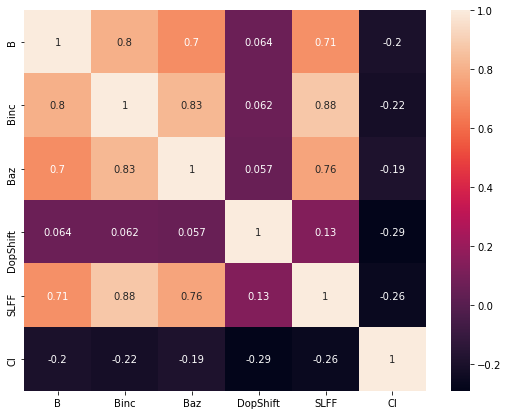

In [21]:

fig = plt.figure(figsize = (9,7))
sn.heatmap(corrMatrix, annot=True)
plt.show()
fig.savefig('corwhole.png')

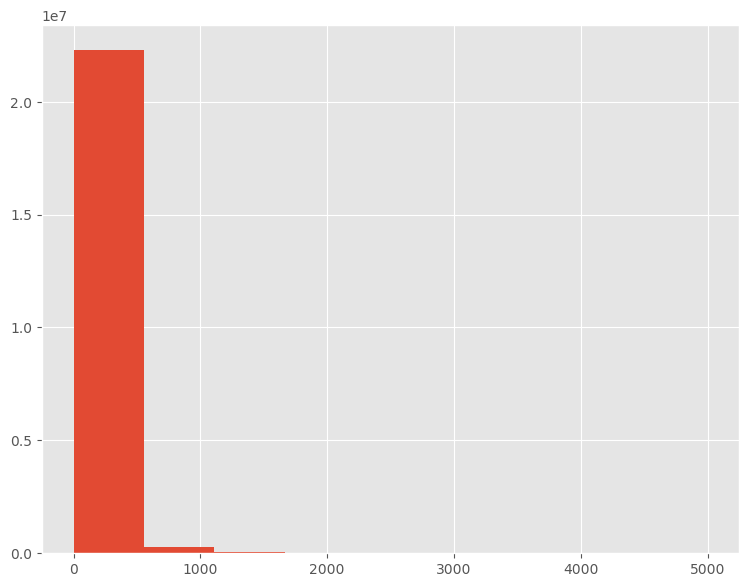

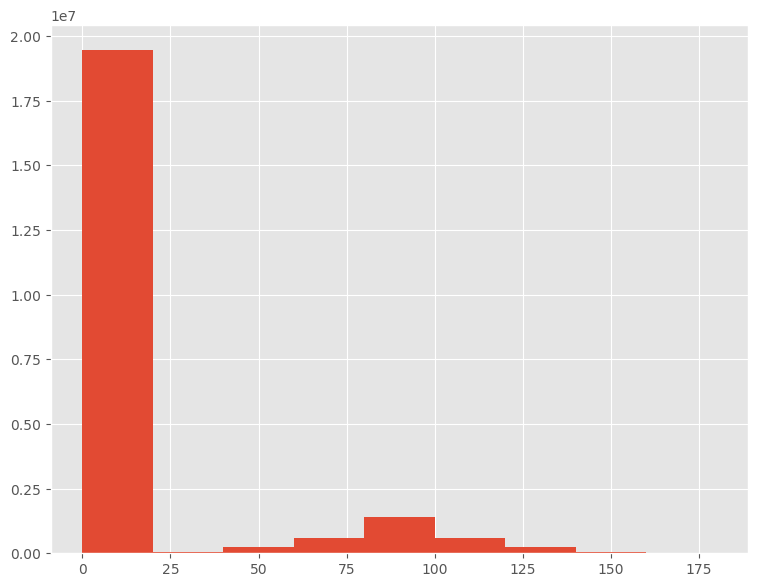

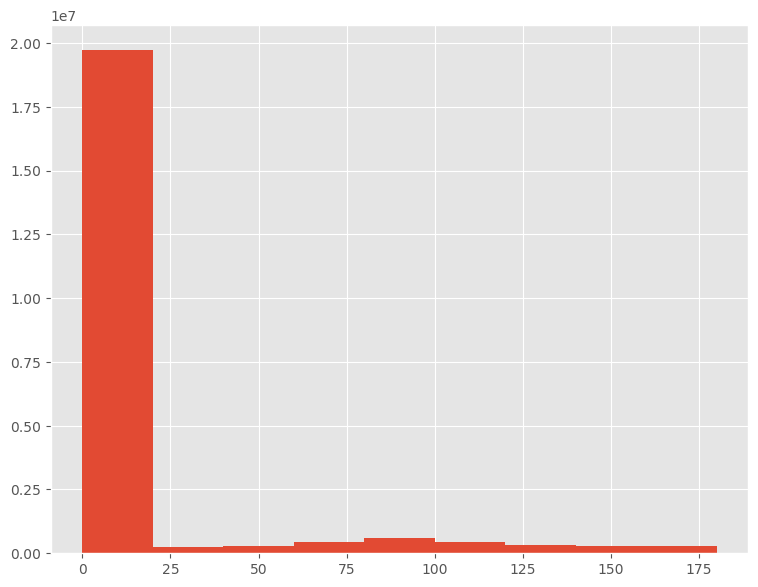

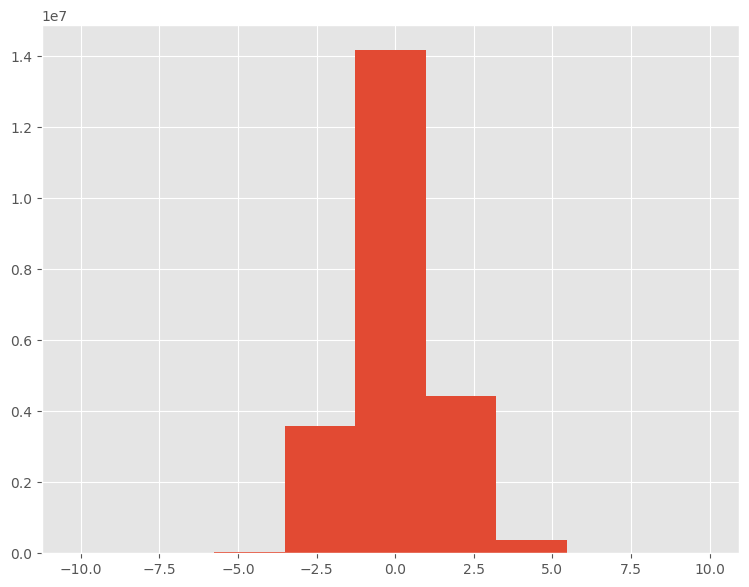

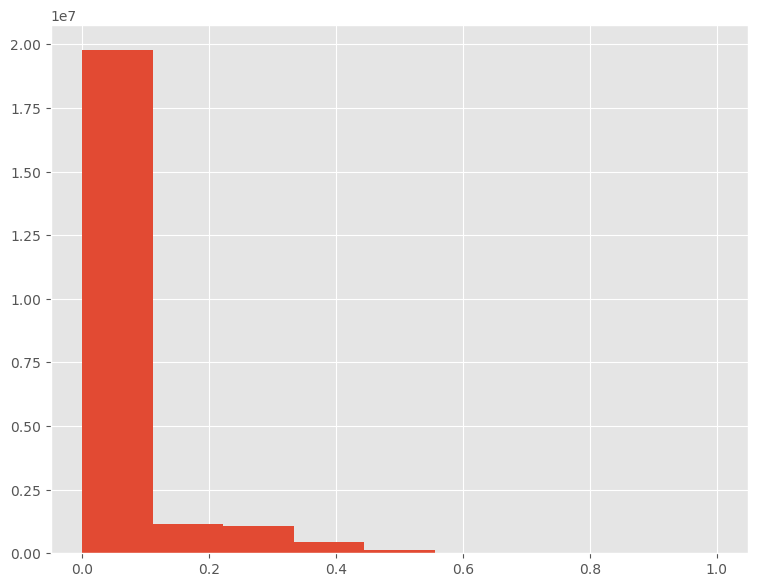

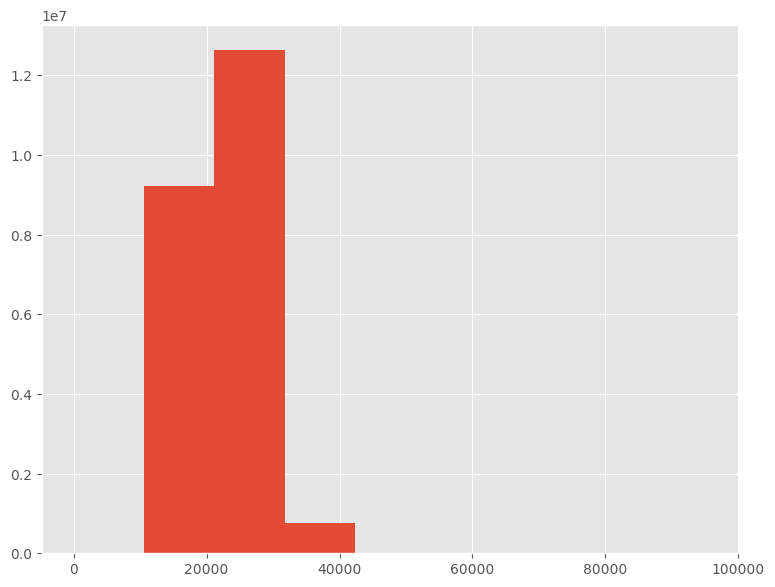

In [30]:
for i in df:
    fig = plt.figure(figsize=(9, 7), dpi=100)
    plt.style.use('ggplot')
    plt.hist(df[i], bins= int(np.sqrt(len(df[i]))/500))
    fig.savefig('set1/'+ i+ 'hist.png')